In [ ]:
from IPython.display import clear_output
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler # проверить все

In [ ]:
import pandas as pd
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
%matplotlib inline

import os, time
import warnings
warnings.filterwarnings("ignore")

In [ ]:
analyze_period = 10000    # Сколько баров в прошлое берем для тренировки модели
ensemble = 5
forvard_lag = 0

In [ ]:
path_data = '/content/drive/MyDrive/_Проекты/Пальмовое масло/data/'
path_models = '/content/drive/MyDrive/_Проекты/Пальмовое масло/models/'
file_X = 'dataframe_1.csv'
file_Y = 'dataframe_Y.csv'
os.chdir(path_data)
print(os.listdir())

['Tseny_2010-20.xlsx', 'dataframe_pct_change.csv', 'dataframe_Y.csv', 'dataframe_1.csv', 'spisok_factors_for_del.txt']


In [ ]:
# Получим список факторов, которые нужно удалить из Х
os.chdir(path_data)
with open('spisok_factors_for_del.txt', 'r') as f:
    spisok_factors_for_del = f.read()
spisok_factors_for_del = spisok_factors_for_del.split("\n")
spisok_factors_for_del

['Sunoil, EU, fob N.W.Eur. ports',
 'Sunoil, Arg., fob',
 'Sunoil, Ukraine, fob',
 'Rape oil, Dutch, fob ex-mill',
 'Palmkernel oil, Mal., cif Rot.',
 'Coconut oil, Phil., cif Rot.']

In [ ]:
os.chdir(path_models)
models_list = os.listdir()
models_list

['model_Conv.h5', 'model_Dense.h5', 'model_LSTM.h5']

### Dataset loading

In [ ]:
os.chdir(path_data)

In [ ]:
#Загрузка данных
data_X = pd.read_csv(file_X, sep=",", index_col=['date'])
data_X = data_X[-analyze_period:] # Убрали устаревшую информацию
print(data_X.shape)
data_X[-3:]

(2652, 10)


,"Soybean oil, Brazil, fob","Soybean oil, Argentina, fob","Sunoil, EU, fob N.W.Eur. ports","Sunoil, Arg., fob","Sunoil, Ukraine, fob","Rape oil, Dutch, fob ex-mill","Palm olein RBD, Mal., fob","Palmkernel oil, Mal., cif Rot.","Coconut oil, Phil., cif Rot.","Пальмовое масло RBD, FOB Малайзия , usd/тн"
date,,,,,,,,,,
2020-10-22,930,850,1020,1000.0,990.0,932,778,820,1125,920.0
2020-10-23,928,847,1025,1000.0,995.0,927,775,820,1150,917.5
2020-10-26,936,857,1020,1010.0,1000.0,940,805,880,1180,912.5


In [ ]:
del data_X['Пальмовое масло   RBD, FOB Малайзия , usd/тн ']
for i in spisok_factors_for_del: del data_X[i]
data_X[-3:]

,"Soybean oil, Brazil, fob","Soybean oil, Argentina, fob","Palm olein RBD, Mal., fob"
date,,,
2020-10-22,930,850,778
2020-10-23,928,847,775
2020-10-26,936,857,805


In [ ]:
# Загрузка Y
data_Y = pd.read_csv(file_Y, sep=",", index_col=['date'])
data_Y.rename(columns={'Пальмовое масло   RBD, FOB Малайзия , usd/тн ': 'Y'}, inplace=True)
data_Y = data_Y[-analyze_period:] # Убрали устаревшую информацию
print(data_Y.shape)
data_Y[-3:]

(2652, 1)


,Y
date,
2020-10-22,920.0
2020-10-23,917.5
2020-10-26,912.5


### Функции разделения массива на ансамбли

In [ ]:
"""
#### Функция разделения массива на выборки для обучения нейросети 
"""
# sequence = строка массива df
# trend = число баров в прошлом для анализа - необходимо найти оптимальный!!
# forvard_lag = предсказание какого бара в будущем делаем 

def split_sequence(sequence, ensemble, forvard_lag=0):
  # sequence = df.values - это массив из данных
  # trend = число баров в прошлом для анализа
  X = list()
  for i in range(len(sequence)):
    end_ix = i + ensemble # находим конечный индекс строки
    if end_ix + (forvard_lag-1) > len(sequence)-1: # cпроверем чтобы не выйти за пределы массива
      break 
    # получаем X и y
    seq_x = sequence[i:end_ix]
    X.append(seq_x)

  return array(X)

## Prediction

### Подготовка данных для подачи в модель для предикта

In [ ]:
xTrain = data_X.values
print('xTrain.shape: ', xTrain.shape)

xTrain.shape:  (2652, 3)


In [ ]:
xScaler = StandardScaler()
#xScaler = RobustScaler()
#xScaler = MinMaxScaler()
xScaler.fit(xTrain)
xTrain = xScaler.transform(xTrain)
print('xTrain[-1]: ', xTrain[-1])
print('xScaler.inverse_transform(xTrain[-1:]):', xScaler.inverse_transform(xTrain[-1:]))

xTrain[-1]:  [0.39518643 0.03130969 0.21344575]
xScaler.inverse_transform(xTrain[-1:]): [[936. 857. 805.]]


In [ ]:
# Формируем выборки для обучения нейросети
xTrain = split_sequence(xTrain, ensemble, forvard_lag=0)
print(xTrain.shape)
print('xTrain[-1]:\n', xTrain[-1])
print('xScaler.inverse_transform(xTrain[-1]):\n', xScaler.inverse_transform(xTrain[-1]))

(2648, 5, 3)
xTrain[-1]:
 [[ 0.32480807 -0.09972126 -0.02974415]
 [ 0.30972699 -0.06444369  0.03234689]
 [ 0.36502428 -0.00396787  0.07374091]
 [ 0.35497022 -0.01908683  0.05821815]
 [ 0.39518643  0.03130969  0.21344575]]
xScaler.inverse_transform(xTrain[-1]):
 [[922. 831. 758.]
 [919. 838. 770.]
 [930. 850. 778.]
 [928. 847. 775.]
 [936. 857. 805.]]


### Предикт по трем сохраненным моделям и отгрисовка графика

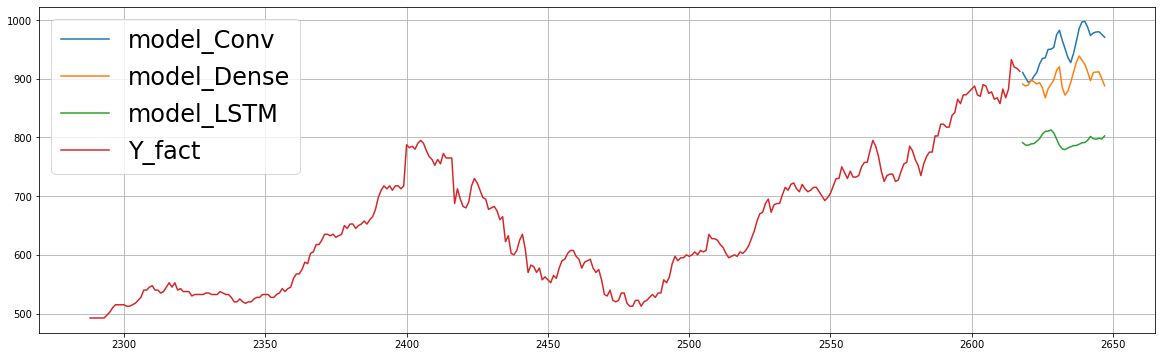

In [ ]:
df_pred = pd.DataFrame()

for model_name in models_list:
  # Загружаем модель и расшифровываем настройки ансамблей
  #ensemble = int(model_name[12:14])
# ---------------------------------------------------------------------------

  file = model_name
  os.chdir(path_models)
  model = load_model(file)

  predictions = model.predict(xTrain)
  #print(model_name, predictions.shape, '\n', predictions[-3:], '\n')

  # Преоразования дляг рафика
  predictions[:-30] = np.NaN
  predictions = predictions.reshape(predictions.shape[0])
  df_pred[model_name[:-3]] = predictions

#df_pred
# Добавляем в датасет Y_fact
# Удалим из датафрейма Y начало из 34 элементов
data_Y_modify = data_Y[34:]   #берем последние 2618 элементов
#Запишем колонку date в другой датафрейм, а Y оставим без него
index_data_Y = pd.DataFrame(data_Y_modify.index)
Y_1 = data_Y_modify.values
#Теперь допишем нулями 30 значений вперед
for x in range(30):
    Y_1 = np.append(Y_1, [np.nan])

#Запишем данные Y в основной датафрейм предсказания
df_pred['Y_fact'] = Y_1
#df_pred[-35:]

# ---------------- график --------------------

col_names = ','.join(df_pred.columns)
col_names = col_names.split(',')

fig,axes = plt.subplots(nrows=1, ncols=1, figsize=(20,6)) 
#  Методы, отображающие данные:
axes.plot(df_pred[-360:]) # вывведем последний год цен на масло
axes.legend(col_names, fontsize=24)
axes.grid()
#ax.legend(["AAA", "BBB"]);
plt.show()

# Пути улучшения продукта:
1. Подбор архитектуры нейронной сети
2. Подбор ансамблей (пакетор данных)
3. Более глубокий анализ влияния факторов и осообености их учета в прогнозировании цены. К сожалению, сейчас анализ выявил "неприятную" особенность: факторы меняют влияние на цену от сильного положительного влияния до сильного отрицательного в зависимости от периода (см файл подготовки датасета)
4. Проведение форвардного анализа (чтобы понять необходимость и частоту переобучения нейронки)